## Quick Docker Commands/Set-Up:


docker build -t "name" -f "Dockerfile.txt" .

docker build -t "get_complete" -f "Dockerfile.txt" .

---
```bash
docker run --entrypoint /bin/bash -it -v /Users/faith/Desktop/Coding:/home/xf2217 get_complete``

docker run -it -p 8888:8888 -v /Users/faith/Desktop/Coding:/home/xf2217  get_complete  jupyter notebook --allow-root --ip 0.0.0.0 --no-browser --NotebookApp.token='' --NotebookApp.password='' --notebook-dir=/home/xf2217
```

---

With Meluxina:
### *Solution:*

```bash
module load Python/3.11.3-GCCcore-12.3.0 

#If a package doesn't work.
rm -rf /home/users/u102501/.local/lib/python3.12/site-packages/urllib3*
python -m pip install --upgrade --force-reinstall urllib3
python -c "import urllib3; print(urllib3.__version__)"
```

```bash
apptainer exec --bind /project/home/p200469/get_BIO1018 get_complete_latest.sif python -m jupyter lab --no-browser --ip "*" --NotebookApp.token='' --NotebookApp.password='' --notebook-dir /project/home/p200469/get_BIO1018 --port 8888
```

Split terminal screen:

In local machine:

`ssh -L 8888:localhost:8888 [u102501@login.lxp.lu](mailto:u102501@login.lxp.lu) -p 8822 -i ~/.ssh/id_ed25519_mlux`

Enter passphrase,

Then,

`ssh -L 8888:localhost:8888 <mel0000>`  swap <> for your node.

## Start of Code:

In [1]:
#%%
from pathlib import Path

import numpy as np
import snapatac2 as snap
from gcell._settings import get_setting

annotation_dir = get_setting('annotation_dir')
print("gcell currently using annotation directory:", annotation_dir)

gcell currently using annotation directory: /home/users/u102501/.gcell_data/annotations


### Download the necessary files

__Adapting for MCF7__ 

Galaxy:
https://usegalaxy.eu/datasets/4838ba20a6d86765d1685afe6504d674/preview

ENCODE View:
https://www.encodeproject.org/search/?searchTerm=mcf7&type=Dataset #Overall MCF7 sample datasets  
https://www.encodeproject.org/reference-epigenomes/ENCSR247DVY/ #MCF7 Reference - containing multiple bioassays.  
https://www.encodeproject.org/annotations/ENCSR074VNQ/ #MCF7 cCRE annotation file - checked on Galaxy and is same format to one used in  tutorial.

Use rsync to transport directory of files to remote server,
or,
curl directly from the terminal:
curl -o MCF7_IDR_thresholded_peaks.bed.gz https://www.encodeproject.org/files/ENCFF882OVP/@@download/ENCFF882OVP.bed.gz
curl -o cCRE_hg38.bed.gz https://www.encodeproject.org/files/ENCFF377XIH/@@download/ENCFF377XIH.bed.gz

-O: Saves the file with its original name.
-o: Allows you to specify a custom name for the downloaded file.

Error:
using curl causes the file to download as a HTML file rather than a real, valid gzip file.

Use:
wget https://www.encodeproject.org/files/ENCFF377XIH/@@download/ENCFF377XIH.bed.gz
wget https://www.encodeproject.org/files/ENCFF882OVP/@@download/ENCFF882OVP.bed.gz - IDR Threshold Peaks
wget https://www.encodeproject.org/files/ENCFF607OSL/@@download/ENCFF607OSL.bam - ATAC-Seq BAM File

Swapping to isogenic replicate 1 as I also have peak counts:
rsync MCF7_IDR_thresholded_peaks.bed meluxina:/project/home/p200469/get_BIO1018/
rsync peak_counts.txt meluxina:/project/home/p200469/get_BIO1018/


In [2]:
#cCRE

import pandas as pd
from pyranges import PyRanges as pr

cols = ["Chromosome", "Start", "End", "Name", "Score", "Strand", "SignalValue", "PValue", "QValue", "SummitOffset", "Color", "DNase", "Classification"] 
#Columns variable to change name

#Here I've created a variable called cre which is an object related to the "cCRE_hg38.tsv.gz" file and stands for candidate cis-regulatory elements.
cre = pd.read_csv('cCRE_hg38.bed.gz', sep='\t', header=None, names=cols)
#Pandas which as an open-source Python library used for data manipulation and analysis. It's similar to dplyr on R. It can read and write Excel files
# So cre is the csv file that was downloaded and is read by the "pandas" tool which we made an alias to refer to is as "pd". Similar to R, the separator is noted.

cre = cre[["Chromosome", "Start", "End"]]

cre = pr(cre, int64=True).sort()
#This line converts the cre DataFrame into a PyRanges object with 64-bit integer precision (int64=True).
#Then sorts the genomic intervals in the object by their position (first by Chromosome and then by Start position).

cre.head()
#To view the first few lines of the file.

,Chromosome,Start,End
0,chr1,104896,105048
1,chr1,138866,139134
2,chr1,180743,180904
3,chr1,181014,181237
4,chr1,181289,181639
5,chr1,267925,268171
6,chr1,271226,271468
7,chr1,274329,274481


### Candidate Cis-Regulatory Elements
Candidate cis-regulatory elements are genomic regions identified as having potential regulatory functions, such as enhancers or promoters, that control gene expression. The file being referenced (cCRE_hg38.tsv.gz) likely contains information about these elements for the human genome (hg38 build).

__What Has Been Done so Far?__
1. Read in a cCRE file. (It's in a compressed from and separated by tabs) 
2. Renamed the columns and selected only the first three.
3. Converted the Pandas Dataframe to a Pranges object that is commonly used for genomic data and workflows (e.g., finding overlaps, merging regions). 
4. Then sorted the Pyranges object by Chromosome and then Start position.
5. Viewed first few lines to ensure all looks good.

__Adapting for MCF7__
The pbmc HDF5 dataset contains both gene expression and peak data in the one file.
For the initial stage of my project I will only be incoporating ATAC-Seq data from ENCODE using IDR thresholded peaks (.bed). Thus, some adaptations need to be made to the code.

In [3]:
cols2 = ["Chromosome", "Start", "End", "Name", "Score", "Strand", "SignalValue", "PValue", "QValue", "SummitOffset", "Counts"]
#Columns variable to change name

#peaks = pd.read_csv("MCF7_IDR_thresholded_peaks.bed", sep="\t", header=None, names=cols2)
peaks = pd.read_csv("peak_counts.txt", sep="\t", header=None, names=cols2)
#Reading in with Pandas and using cols vector to change column names.

peaks = peaks[["Chromosome", "Start", "End", "Counts"]]
#Selecting only the first four columns

# Convert Start and End to integers
#peaks["Start"] = peaks["Start"].astype(int)
#peaks["End"] = peaks["End"].astype(int)
#I don't think these lines are necessary as it isn't an AnnData object like the tutorial data.

peaks = peaks.drop_duplicates()

peaks = pr(peaks, int64=True).sort()
# Returns the shape (number of rows and columns) of the PyRanges DataFrame

# Display the first few rows
# peaks.head()

print(peaks.df.shape)
print(peaks.head())
#Display number of rows and columns

#This code processes genomic peak data, converting it into a more usable format for analysis.


(66854, 4)
+--------------+-----------+-----------+-----------+
| Chromosome   |     Start |       End |    Counts |
| (category)   |   (int64) |   (int64) |   (int64) |
|--------------+-----------+-----------+-----------|
| chr1         |    778344 |    779182 |       799 |
| chr1         |    826784 |    828131 |      1091 |
| chr1         |    845602 |    846425 |       186 |
| chr1         |    869615 |    870280 |       132 |
| chr1         |    904215 |    904959 |       629 |
| chr1         |    905053 |    905216 |        36 |
| chr1         |    921100 |    921389 |       301 |
| chr1         |    923712 |    925287 |       841 |
+--------------+-----------+-----------+-----------+
Unstranded PyRanges object has 8 rows and 4 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome.


### FuXi Note:
For optimal zero-shot analysis, it is recommended to use a union set of peaks from both the new dataset and the original training peak sets *(i.e. the cre peaks defined above)* to minimize domain shift. However, in this tutorial we will simply perform finetuning using the new peak set from the 10x PBMC multiome data. The union peak set can be constructed as below. 

After that you should re-count the peak count matrix using fragment file, and when write out cell-type specific peaks, ideally remove all non-accessible peaks in each cell types.

---

The BAM file for the MCF7_IDR_thresholded_peaks.bed file should be used to recount the peaks after unionization. For now I will also use the peaks variable alone and come back once all the code is written and passes through.

In [4]:
#peak / cre + cre 
#find all peaks that don't overlap with cre; -> non_overlap_peaks

non_overlap_peaks = peaks.overlap(cre, invert=True)
#invert=True: Ensures that only peaks (from MCF7 file) outside the cre regions are kept. i.e. keeping MCF7 peaks that don't overlap with cre.

#concat with cre and sort
total_peaks = pd.concat([non_overlap_peaks.df, cre.df], ignore_index=True)
#The ignore_index=True parameter in the pd.concat() function tells pandas to re-index the resulting DataFrame after concatenation. 
#Without it, pandas would retain the original indices from the two DataFrames being concatenated, which could result in duplicated indices if the DataFrames have overlapping index values.
#So now this total_peaks variable contains the peaks in MCF7 dataset that don't overlap with cre, and cre. So it is a unique dataset.

total_peaks = pr(total_peaks, int64=True).sort()

#remove chromosome M, Y and those not start with chr
total_peaks = total_peaks.df.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')
total_peaks.shape

(1067375, 4)

### What is the Purpose of This?

In this code, cre represents candidate cis-regulatory elements (genomic regions with potential regulatory roles), while peaks represents regions of open chromatin from the experimental data, inferred from ATAC-seq or other assays.

The overlapping is done to identify non-overlapping peaks using:

This step filters peaks that do not overlap with the cCRE regions. The purpose is to isolate peaks not previously annotated as regulatory elements, which may contain novel or unique regions worth further analysis.

So now this total_peaks (or union set) variable contains the peaks in MCF7 dataset that don't overlap with cre, and cre. So it is a unique dataset.

### FuXi Note:
For convenience, we will keep using the peak set called by cellranger here. Note that there is a difference in peak length distribution. However, in general there are no peaks > 1000 bp; and most peaks have a length in order of 10^3 so let's keep using this one. Note that the original training CRE peak set has a unified length of 400 bp.

---

__Adapting for MCF7__
So to adapt this for eventual fine tuning with MCF7, I will use the union set (total_peaks)

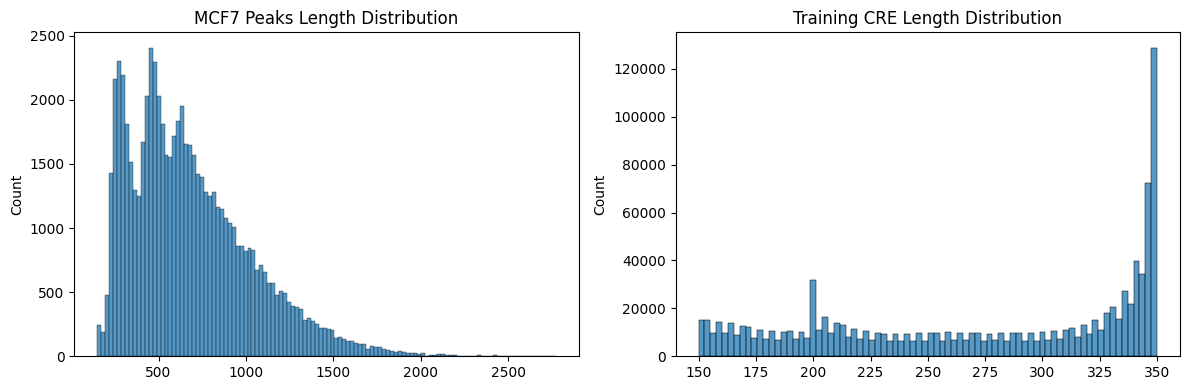

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#plt.subplots(1, 2, figsize=(12, 4)): This creates a figure with two subplots arranged horizontally (1 row, 2 columns).
#The figsize=(12, 4) argument specifies the dimensions of the overall figure in inches (width = 12 inches, height = 4 inches).
#ax1, ax2: These are the axes for the left and right subplots, respectively. 

#sns.histplot(total_peaks.End-total_peaks.Start, ax=ax1)
#Zero-shot analysis, (after pass-through)

sns.histplot(peaks.End-peaks.Start, ax=ax1)
#sns.histplot(peaks.End-peaks.Start, ax=ax1): This plots a histogram of the length of each peak in the peaks DataFrame. 
#The length is calculated by subtracting the Start coordinate from the End coordinate (peaks.End - peaks.Start), which gives the length of each peak region.
#The ax=ax1 argument tells Seaborn to plot this histogram on the left subplot (ax1).

ax1.set_title('MCF7 Peaks Length Distribution')

sns.histplot(cre.End-cre.Start, ax=ax2)  
#sns.histplot(cre.End-cre.Start, ax=ax2): This plots a histogram of the length of each candidate cis-regulatory element (CRE) in the cre DataFrame.
#Similarly, the length is calculated by subtracting the Start coordinate from the End coordinate (cre.End - cre.Start).
#The ax=ax2 argument tells Seaborn to plot this histogram on the right subplot (ax2).

ax2.set_title('Training CRE Length Distribution')

plt.tight_layout()

## Chromosome Assignment
I won' be using RNA-Seq data, so the only thing I need to be focused on is getting the:
Peak accessibility file (.atac.bed) containing:  
Peak coordinates (chr, start, end)  
Normalized accessibility scores (aCPM, 10^5 scale factor) 

Then exporting that into zarr for the next steps. A lot of alteration will be necessary.

### FuXi Note:
We filter for cell types with >100 cells and at least 3M library size.
The selected cell types will be used for training GET models.

_Adapt for chromosomes_

In [6]:
#Adapted:
# Convert PyRanges object to Pandas DataFrame
peaks_df = peaks.df  # Extract the Pandas DataFrame

# Count the number of peaks per chromosome
chromosome_peak_counts = peaks_df.groupby('Chromosome', observed=False).size().to_dict()

# Print message
print("The following chromosomes have more than 100 peaks and a total read count > 3M, adding them to chromosomes_for_modeling:")

# Initialize list to store chromosomes meeting criteria
chromosomes_for_modeling = []

# Loop through each chromosome and its corresponding peak count
for chrom in chromosome_peak_counts:
    # If the chromosome has more than 100 peaks
    if chromosome_peak_counts[chrom] > 100:
        # Calculate "library size" (total Signal_Value for the chromosome)
        libsize = int(peaks_df[peaks_df.Chromosome == chrom]["Counts"].sum())
        
        # If the library size is greater than 1M, add it to the list and print info
        #Had to reduce to 1M for my dataset
        if libsize > 1000000:
            chromosomes_for_modeling.append(chrom)
            print(f"{chrom} number of peaks: {chromosome_peak_counts[chrom]}, library size: {libsize}")


The following chromosomes have more than 100 peaks and a total read count > 3M, adding them to chromosomes_for_modeling:
chr1 number of peaks: 6216, library size: 2882439
chr10 number of peaks: 3295, library size: 1256758
chr11 number of peaks: 3048, library size: 1440440
chr12 number of peaks: 3188, library size: 1476326
chr14 number of peaks: 2568, library size: 1311225
chr15 number of peaks: 2647, library size: 1269800
chr16 number of peaks: 2641, library size: 1505808
chr17 number of peaks: 3623, library size: 2496513
chr19 number of peaks: 2753, library size: 1657151
chr2 number of peaks: 5191, library size: 2083561
chr20 number of peaks: 2729, library size: 1899695
chr3 number of peaks: 4103, library size: 1732083
chr5 number of peaks: 3642, library size: 1556015
chr6 number of peaks: 3650, library size: 1456372
chr7 number of peaks: 3542, library size: 1683685
chr8 number of peaks: 3147, library size: 1518449
chr9 number of peaks: 2734, library size: 1265348


## 2. Export Training Data

### FuXi Note:
For each abundant cell type, we'll generate:

Peak accessibility file (.atac.bed) containing:  
Peak coordinates (chr, start, end)  
Normalized accessibility scores (aCPM, 10^5 scale factor)  

In [7]:
# This should be the same as the peaks variable defined above.

# Import pandas library for data manipulation and pyranges for genomic range operations
import pandas as pd
from pyranges import PyRanges as pr

def get_peak_from_file(file_path: str):
    """
    Reads a peak file and returns a PyRanges object with chromosome positions and read counts.

    Args:
        file_path (str): Path to the peak counts file.

    Returns:
        PyRanges: A PyRanges object with peak data including chromosome, start, end, and counts.
    """
    # Define column names for the file
    cols = ["Chromosome", "Start", "End", "Name", "Score", "Strand", "SignalValue", "PValue", "QValue", "SummitOffset", "Counts"]

    # Read the file
    peaks_df = pd.read_csv(file_path, sep="\t", header=None, names=cols)

    # Ensure numeric columns are properly formatted
    #peaks_df["Start"] = peaks_df["Start"].astype(int)
    #peaks_df["End"] = peaks_df["End"].astype(int)
    #Not necessary.

    peaks_df = peaks_df[["Chromosome", "Start", "End", "Counts"]]

    peaks_df = peaks_df.drop_duplicates()

    # Convert to PyRanges for efficient genomic operations
    peaks = pr(peaks_df)

    return peaks

# Example usage
peaks = get_peak_from_file("peak_counts.txt")

# Display the shape of the DataFrame
print(peaks.df.shape)  # Output (rows, columns)

(66854, 4)


In [8]:
import numpy as np
import pandas as pd
from pyranges import PyRanges as pr

def get_peak_acpm_for_chromosome(file_path: str):
    """
    Calculate the aCPM (normalized counts) for each chromosome.

    Args:
        file_path (str): Path to the peak counts file.

    Returns:
        pd.DataFrame: DataFrame containing peaks with aCPM values.
    """
    # Read the peak counts file
    peaks = get_peak_from_file(file_path).df  # Using our previous function

    # Get total counts per peak
    counts = np.array(peaks["Counts"]).flatten()

    # Compute aCPM (adjusted counts per million) using log10 transformation
    acpm = np.log10(counts / counts.sum() * 1e5 + 1)

    # Normalize the aCPM values so that the maximum value is 1
    peaks["aCPM"] = acpm / acpm.max()

    # Filter out unwanted chromosomes (e.g., Mitochondrial, Y, and 'chrUn' entries)
    peaks = peaks.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')

    # Convert back to PyRanges for efficiency, then sort and return as a DataFrame
    return pr(peaks, int64=True).sort().df

# Example usage
acpm_peaks = get_peak_acpm_for_chromosome("peak_counts.txt")

# Display first few rows
print(acpm_peaks.head())

  Chromosome   Start     End  Counts      aCPM
0       chr1  778344  779182     799  0.263836
1       chr1  826784  828131    1091  0.312437
2       chr1  845602  846425     186  0.096958
3       chr1  869615  870280     132  0.073133
4       chr1  904215  904959     629  0.229263


### FuXi Note:
Let's run the function above to save the peak with aCPM for all cell types (chromsomes for me). Note that here we use the common peak set for all cell types. Later in the dataset we will be able to filter out peaks with no accessibility for each cell type.

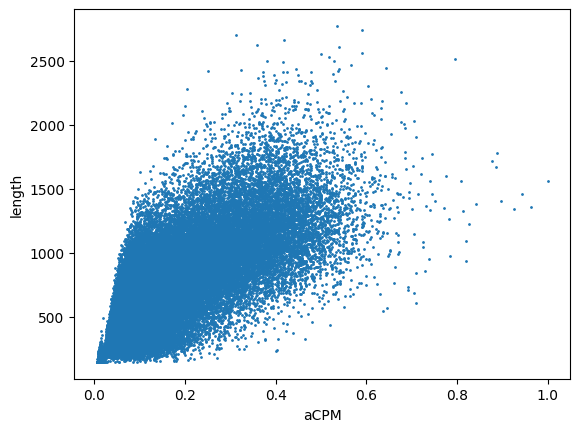

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyranges import PyRanges as pr

def save_acpm_per_chromosome(file_path: str) -> pd.DataFrame:
    """
    Computes and saves aCPM (adjusted counts per million) for each chromosome.

    Args:
        file_path (str): Path to the peak counts file.

    Returns:
        pd.DataFrame: Processed peaks DataFrame with only 'Chromosome', 'Start', 'End', and 'aCPM'.
    """
    # Compute aCPM for all peaks
    peaks = get_peak_acpm_for_chromosome(file_path)

    # Drop duplicate rows (if any)
    peaks = peaks.drop_duplicates()

    # Keep only relevant columns
    peaks = peaks[["Chromosome", "Start", "End", "aCPM"]]

    # Ensure proper sorting
    peaks = peaks.sort_values(by=["Chromosome", "Start", "End"])

    # Loop through each unique chromosome and save to individual .bed files
    for chrom in peaks["Chromosome"].unique():
        chrom_peaks = peaks[peaks["Chromosome"] == chrom]
        chrom_filename = f'{chrom}.atac.bed'
        chrom_peaks.to_csv(chrom_filename, sep='\t', index=False, header=False)

    return peaks  # Return the modified DataFrame

# Run processing
processed_peaks = save_acpm_per_chromosome("peak_counts.txt")

# ✅ Fix: Compute 'length' **BEFORE** plotting
processed_peaks["length"] = processed_peaks["End"] - processed_peaks["Start"]

# ✅ Fix: Use `processed_peaks` for the plot
processed_peaks.plot(y='length', x='aCPM', kind='scatter', s=1)

# ✅ Ensure the plot actually displays
plt.show()

In [11]:
peaks = processed_peaks
peaks

,Chromosome,Start,End,aCPM,length
0,chr1,778344,779182,0.263836,838
1,chr1,826784,828131,0.312437,1347
2,chr1,845602,846425,0.096958,823
3,chr1,869615,870280,0.073133,665
4,chr1,904215,904959,0.229263,744
...,...,...,...,...,...
66846,chrX,155819924,155820493,0.071255,569
66847,chrX,155880939,155881698,0.299576,759
66848,chrX,155966907,155967513,0.066002,606
66849,chrX,156013435,156013968,0.094441,533


## 3. Query motifs and save data as zarr files.

In [10]:
# NOTE: tabix has to be >= 1.17
! tabix --version

tabix (htslib) 1.21
Copyright (C) 2024 Genome Research Ltd.


In [11]:
# Import the necessary libraries and modules
import os
from pathlib import Path

# Import specific functions from the 'gcell._settings' module and 'preprocess_utils' module
from gcell._settings import get_setting
from preprocess_utils import (
    add_atpm,        # Function to add ATPM (likely a type of data or calculation)
    add_exp,         # Function to add expression data
    create_peak_motif,  # Function to create peak motif data
    download_motif,     # Function to download motif data
    get_motif,          # Function to retrieve motif data
    query_motif,        # Function to query motif data
)

# Get the annotation directory setting using the 'get_setting' function and convert it to a Path object
annotation_dir = Path(get_setting('annotation_dir'))

# Print the directory being used for annotations (retrieved from the configuration)
print("gcell currently using annotation directory:", annotation_dir)

gcell currently using annotation directory: /home/users/u102501/.gcell_data/annotations


### Download motif bed file

In [12]:
motif_bed_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz"
motif_bed_index_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz.tbi"


if (
    motif_bed_url
    and motif_bed_index_url
    and not (
        (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz").exists()
        or (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz.tbi").exists()
    )
):
    download_motif(motif_bed_url, motif_bed_index_url, motif_dir=annotation_dir)
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")
else:
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")

### Query Motif

In [13]:
# List of chromosome-based peak files (assuming they are saved as `chr1.atac.bed`, `chr2.atac.bed`, ...)
chromosomes = [f"chr{i}" for i in range(1, 23)]

# Loop through each chromosome
for chrom in chromosomes:
    peak_bed = f"{chrom}.atac.bed"  # Assuming peak files are named per chromosome

    if os.path.exists(peak_bed):  # Ensure the peak file exists
        print(f"Processing motifs for {chrom}...")

        # Query motif file for the current chromosome's peak file
        peaks_motif = query_motif(peak_bed, motif_bed)

        # Process the queried motif data
        motif_output = get_motif(peak_bed, peaks_motif)

        # Save results per chromosome
        os.rename(motif_output, f"{chrom}.motif.bed")

        print(f"Motif processing completed for {chrom}, saved as {chrom}.motif.bed")
    else:
        print(f"Skipping {chrom}, peak file {peak_bed} not found.")

Processing motifs for chr1...
Peak motif extraction completed. Results saved in get_motif.bed
Motif processing completed for chr1, saved as chr1.motif.bed
Processing motifs for chr2...
Peak motif extraction completed. Results saved in get_motif.bed
Motif processing completed for chr2, saved as chr2.motif.bed
Processing motifs for chr3...
Peak motif extraction completed. Results saved in get_motif.bed
Motif processing completed for chr3, saved as chr3.motif.bed
Processing motifs for chr4...
Peak motif extraction completed. Results saved in get_motif.bed
Motif processing completed for chr4, saved as chr4.motif.bed
Processing motifs for chr5...
Peak motif extraction completed. Results saved in get_motif.bed
Motif processing completed for chr5, saved as chr5.motif.bed
Processing motifs for chr6...
Peak motif extraction completed. Results saved in get_motif.bed
Motif processing completed for chr6, saved as chr6.motif.bed
Processing motifs for chr7...
Peak motif extraction completed. Results

## 4. Create Peak Motif .Zarr File

Create a peak x motif matrix stored in a zarr file. If you are working on multiple cell types with the same peak set, you can use the same peak bed and zarr file for all cell types.


In [14]:
import os
import pandas as pd
import zarr
import numpy as np
from numcodecs import Blosc, VLenUTF8  # Use VLenUTF8 for string storage

def create_peak_motif_per_chromosome(output_zarr_dir):
    """
    Process peak motifs per chromosome and save as separate Zarr files.

    Args:
        output_zarr_dir (str): Directory where Zarr files should be stored.
    """

    # Define chromosomes to process
    chromosomes = [f"chr{i}" for i in range(1, 23)]

    # Ensure the output directory exists
    os.makedirs(output_zarr_dir, exist_ok=True)

    for chrom in chromosomes:
        peak_motif_bed = f"{chrom}.motif.bed"
        peak_bed = f"{chrom}.atac.bed"
        output_zarr = os.path.join(output_zarr_dir, f"{chrom}.zarr")

        if os.path.exists(peak_motif_bed) and os.path.exists(peak_bed):
            print(f"Processing {chrom} motif data...")

            # Read the peak motif bed file
            peak_motif = pd.read_csv(
                peak_motif_bed, sep="\t", header=None,
                names=["Chromosome", "Start", "End", "Motif_cluster", "Score"]
            )

            # Pivot the data
            peak_motif_pivoted = peak_motif.pivot_table(
                index=["Chromosome", "Start", "End"],
                columns="Motif_cluster",
                values="Score",
                fill_value=0
            )
            peak_motif_pivoted.reset_index(inplace=True)

            # Create the 'Name' column
            peak_motif_pivoted["Name"] = peak_motif_pivoted.apply(
                lambda x: f'{x["Chromosome"]}:{x["Start"]}-{x["End"]}', axis=1
            )
            peak_motif_pivoted.drop(columns=["Chromosome", "Start", "End"], inplace=True)

            # Read the original peak bed file
            original_peaks = pd.read_csv(
                peak_bed, sep="\t", header=None, names=["Chromosome", "Start", "End"]
            )

            # Ensure Start and End are integers
            original_peaks["Start"] = original_peaks["Start"].astype(int)
            original_peaks["End"] = original_peaks["End"].astype(int)

            # Create 'Name' column for original peaks
            original_peaks["Name"] = original_peaks.apply(
                lambda x: f'{x["Chromosome"]}:{x["Start"]}-{x["End"]}', axis=1
            )

            # Merge the pivoted data with the original peaks
            merged_data = pd.merge(original_peaks, peak_motif_pivoted, on="Name", how="left")

            # Fill NaN values with 0 for motif columns
            motif_columns = [col for col in merged_data.columns if col not in ["Chromosome", "Start", "End", "Name"]]
            merged_data[motif_columns] = merged_data[motif_columns].fillna(0)

            # Prepare data for Zarr storage
            name_values = merged_data["Name"].values
            motif_values = np.array(motif_columns, dtype="object")  # Ensure string compatibility

            motif_data_matrix = merged_data[motif_columns].values

            # Save to Zarr
            z = zarr.open(output_zarr, mode="w")
            z.create_dataset(
                "data",
                data=motif_data_matrix,
                chunks=(1000, motif_data_matrix.shape[1]),
                dtype=np.float32,
                compressor=Blosc(cname="zstd", clevel=3, shuffle=Blosc.BITSHUFFLE),
                shape=motif_data_matrix.shape
            )
            z.create_dataset("peak_names", data=name_values, dtype="object", object_codec=VLenUTF8())  # Fixed
            z.create_dataset("motif_names", data=motif_values, dtype="object", object_codec=VLenUTF8())  # Fixed

            print(f"✅ {chrom} peak motif data saved to {output_zarr}")

        else:
            print(f"Skipping {chrom}, missing {peak_motif_bed} or {peak_bed}")

# Example Usage:
create_peak_motif_per_chromosome("motif_zarr_output_ATAC_only")

Processing chr1 motif data...
✅ chr1 peak motif data saved to motif_zarr_output_ATAC_only/chr1.zarr
Processing chr2 motif data...
✅ chr2 peak motif data saved to motif_zarr_output_ATAC_only/chr2.zarr
Processing chr3 motif data...
✅ chr3 peak motif data saved to motif_zarr_output_ATAC_only/chr3.zarr
Processing chr4 motif data...
✅ chr4 peak motif data saved to motif_zarr_output_ATAC_only/chr4.zarr
Processing chr5 motif data...
✅ chr5 peak motif data saved to motif_zarr_output_ATAC_only/chr5.zarr
Processing chr6 motif data...
✅ chr6 peak motif data saved to motif_zarr_output_ATAC_only/chr6.zarr
Processing chr7 motif data...
✅ chr7 peak motif data saved to motif_zarr_output_ATAC_only/chr7.zarr
Processing chr8 motif data...
✅ chr8 peak motif data saved to motif_zarr_output_ATAC_only/chr8.zarr
Processing chr9 motif data...
✅ chr9 peak motif data saved to motif_zarr_output_ATAC_only/chr9.zarr
Processing chr10 motif data...
✅ chr10 peak motif data saved to motif_zarr_output_ATAC_only/chr10.za

### Add aCPM data to region x motif matrix

For each cell type, we will save it's aCPM values to the pbmc10k_multiome.zarr/atpm/{celltype}/ folder

In [15]:
#The following chromosomes have more than 100 peaks and a total read count > 3M, adding them to chromosomes_for_modeling:
#chr1 number of peaks: 6216, library size: 2882439
#chr10 number of peaks: 3295, library size: 1256758
#chr11 number of peaks: 3048, library size: 1440440
#chr12 number of peaks: 3188, library size: 1476326
#chr14 number of peaks: 2568, library size: 1311225
#chr15 number of peaks: 2647, library size: 1269800
#chr16 number of peaks: 2641, library size: 1505808
#chr17 number of peaks: 3623, library size: 2496513
#chr19 number of peaks: 2753, library size: 1657151
#chr2 number of peaks: 5191, library size: 2083561
#chr20 number of peaks: 2729, library size: 1899695
#chr3 number of peaks: 4103, library size: 1732083
#chr5 number of peaks: 3642, library size: 1556015
#chr6 number of peaks: 3650, library size: 1456372
#chr7 number of peaks: 3542, library size: 1683685
#chr8 number of peaks: 3147, library size: 1518449
#chr9 number of peaks: 2734, library size: 1265348

chromosomes_for_modeling = [f"chr{i}" for i in range(1, 23)]

In [16]:
import pandas as pd
import zarr
import numpy as np
from pathlib import Path

def add_atpm(zarr_file, bed_file, chrom):
    """
    Add aTPM (ATAC-seq 'Transcript'/Count Per Million) data for a specific chromosome to its Zarr file.

    Args:
        zarr_file (str): Path to the chromosome-specific Zarr file (e.g., "motif_zarr_output_ATAC_only/chr1.zarr").
        bed_file (str): Path to the chromosome-specific BED file (e.g., "chr1.atac.bed").
        chrom (str): Chromosome name (e.g., "chr1").
    """
    # Ensure Zarr directory exists
    zarr_path = Path(zarr_file)
    if not zarr_path.exists():
        print(f"❌ Skipping {chrom}: Zarr file not found at {zarr_file}")
        return
    
    # Ensure BED file exists
    bed_path = Path(bed_file)
    if not bed_path.exists():
        print(f"❌ Skipping {chrom}: BED file not found at {bed_file}")
        return

    # Load BED file containing aTPM data
    df = pd.read_csv(
        bed_file, sep="\t", header=None, names=["Chromosome", "Start", "End", "aTPM"]
    )
    df["Name"] = df.apply(lambda x: f'{x["Chromosome"]}:{x["Start"]}-{x["End"]}', axis=1)

    print(f"✅ Processing {chrom} - Total peaks: {len(df)}")

    # Map peak names to aTPM values
    name_to_atpm = dict(zip(df["Name"], df["aTPM"]))

    # Open chromosome-specific Zarr file
    z = zarr.open(zarr_file, mode="a")

    # Ensure 'atpm' group exists
    if "atpm" not in z:
        z.create_group("atpm")

    # Save aTPM data for the chromosome
    z["atpm"].create_dataset(
        chrom,  # Use chromosome name
        data=np.array([name_to_atpm.get(name, 0) for name in z["peak_names"]]),
        overwrite=True,
        chunks=(1000,),
        dtype=np.float32,
    )

    print(f"✅ aTPM data added to {zarr_file} for {chrom}")


zarr_dir = "motif_zarr_output_ATAC_only"  # Location of Zarr files

for chrom in chromosomes_for_modeling:
    add_atpm(
        f"{zarr_dir}/{chrom}.zarr",  # Correct Zarr file path
        f"{chrom}.atac.bed",  # BED file (assumed in the current working directory)
        chrom
    )

✅ Processing chr1 - Total peaks: 6216
✅ aTPM data added to motif_zarr_output_ATAC_only/chr1.zarr for chr1
✅ Processing chr2 - Total peaks: 5191
✅ aTPM data added to motif_zarr_output_ATAC_only/chr2.zarr for chr2
✅ Processing chr3 - Total peaks: 4103
✅ aTPM data added to motif_zarr_output_ATAC_only/chr3.zarr for chr3
✅ Processing chr4 - Total peaks: 2218
✅ aTPM data added to motif_zarr_output_ATAC_only/chr4.zarr for chr4
✅ Processing chr5 - Total peaks: 3642
✅ aTPM data added to motif_zarr_output_ATAC_only/chr5.zarr for chr5
✅ Processing chr6 - Total peaks: 3650
✅ aTPM data added to motif_zarr_output_ATAC_only/chr6.zarr for chr6
✅ Processing chr7 - Total peaks: 3542
✅ aTPM data added to motif_zarr_output_ATAC_only/chr7.zarr for chr7
✅ Processing chr8 - Total peaks: 3147
✅ aTPM data added to motif_zarr_output_ATAC_only/chr8.zarr for chr8
✅ Processing chr9 - Total peaks: 2734
✅ aTPM data added to motif_zarr_output_ATAC_only/chr9.zarr for chr9
✅ Processing chr10 - Total peaks: 3295
✅ aTPM 

This has conclude the data processing steps.